# Learning Seattle's Work Habits from Bicycle Counts
# 透過自行車流量認識西雅圖上班族工作習慣
*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

參考原文資料 : [Learning Seattle's Work Habits from Bicycle Counts](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/)

#### 以下範例將分成兩部分進行：
#### 第一部分以 2012/10/03~2015/12/31的資料開始分析(與原文作者，使用的時間區間相近)
#### 第二部分以 2016/01/01~2019/05/27進行與第一部分比較分析，討論自行車使用習慣的逐年變化。
-------------------------------------------------------

# 第一部分：
------------------------------------------
## The Data 資料說明、初步觀察

<!-- PELICAN_BEGIN_SUMMARY -->
資料使用西雅圖的佛里蒙特橋([Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965))每小時單車流量。

此資料來自於，2012年下半年安裝在佛里蒙特橋的自動自行車計數器，感應器裝置設置在東西兩側通行道。

資料檔案，從官方資料庫下載[西雅圖的佛里蒙特橋每小時自行車流量](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)

直接下載檔案，可以反註解下方 ``curl`` 指令:
<!-- PELICAN_END_SUMMARY -->

In [1]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

下載好資料後使用 [pandas](http://pandas.pydata.org) 函式庫載入資料 : 

In [1]:
import pandas as pd
data = pd.read_csv('fremont-bridge-hourly-bicycle-counts-by-month-october-2012-to-present.csv',
                   index_col='Date', parse_dates=True)
# index_col='Date' 直接使用資料中的'Date'欄位，做為每筆資料的索引。
# parse_dates=True 嘗試將所有可能的數據解析為時間格式，之後可以直接使用時間對資料做操作。
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-01-01 00:00:00,0.0,9.0
2019-01-01 01:00:00,2.0,22.0
2019-01-01 02:00:00,1.0,11.0
2019-01-01 03:00:00,1.0,2.0
2019-01-01 04:00:00,2.0,1.0


初步的整理資料: 將欄位名稱重新命名，簡化成 "West" 和 "East"。將所有缺失值補0，並新增 "Total" 欄位，表達總流量:

In [2]:
data.columns = ['West', 'East'] # 指定新的欄位名稱
data.fillna(0, inplace=True) # 填補缺失值(NaN)
data['Total'] = data.eval('East + West') # 新增欄位Total，為East、West的總和

選取特定時間區間，mask設定**2016/01/01-2019/06/30**

In [3]:
mask = (data.index >= '2012-10-03') & (data.index <= '2015-12-31')
# 用來選取時間區間的遮罩

data = data.iloc[mask]
data.head()

,West,East,Total
Date,,,
2015-11-15 02:00:00,0.0,0.0,0.0
2015-11-29 04:00:00,0.0,0.0,0.0
2015-11-21 02:00:00,0.0,0.0,0.0
2015-11-08 02:00:00,0.0,0.0,0.0
2015-11-08 04:00:00,0.0,0.0,0.0


使用簡單的視覺化呈現，可以對整體資料有初步掌握。

以下做法，調整資料時間頻率，改為一週一筆數據，單筆數據為單週自行車流量的總和。改變資料密度，再視覺化調整後的資料 :

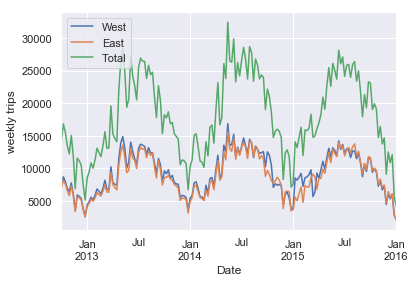

In [4]:
# 先匯入基本函式庫
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # 設定圖表樣式
import numpy as np

data.resample('W').sum().plot() # 透過resample函式，調整資料，再畫出圖表
# 'W':表示將時間頻率轉換為一星期(week)，how='sum':轉變時間頻率後的操作，設定為總和

plt.ylabel('weekly trips'); # y軸標籤

從整體圖表可以看出自行車流量有明顯的季節性變化，而小範圍時間內的流量變化，部分可以根據溫度、每年的時序、降雨量和其他因素做[分析和解釋](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)。

## Extracting Knowledge from the Data 從資料中提取資訊

在做分析時，我們可以以直覺做出推斷，推測自行車流量可能受到那些因素(如天氣、時序)影響，再將推測以程式碼驗證。

但本文的做法則是讓資料自己告訴我們它隱含了哪些資訊，並採取*非監督式(unsupervised)學習*的方式，去學習資料所要告訴我們的資訊。

我們先將每天資料視為獨立個體，每天我們有48個觀測值：東西兩側通行道，各24小時的監測資料。

根據這些觀測值，謹慎的推斷這些日子所隱藏的資訊，我們應該能夠不依靠任何假設，就從資料提取出有意義的量化描述及資訊。

## Transforming the Data 資料呈現方式轉換

將資料轉換成一個二維矩陣，每一列(row)代表一天，欄(column)則表示一天中的48個監測數據。

使用pandas中的``pivot_table()`` 函式可以為我們做到上述的轉換動作。

data中的"East" 和"West" 欄位是我們需要的數據，以日期作為列索引，以當天的每一小時作為欄索引，將資料重新配置。

所有的缺失值則以補0處理 :

In [5]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date, # data中的索引取日期(date)的部分當作pivoted 的列索引
                           columns=data.index.hour, # data中的索引取小時(hour) 當作pivoted 的欄索引
                           fill_value=0)
pivoted.head()

East                                     ... West                 \
Date         0  1  2  3  4   5   6    7    8    9   ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104  ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94  ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81  ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55  ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36  ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

下一步我們提取原數據，將它們轉為矩陣型態:

In [6]:
X = pivoted.values # 建立 X 物件，將 pivoted的值轉存成矩陣型態
X.shape # 查看矩陣大小

(1185, 48)

可以看出我們的資料天數有兩千多天，每天則包含上述的48筆測量值。

## Visualizing the Data 視覺化資料

我們可以將資料視為1185個存在於*48-維*空間的不同物件: 每一個維度的值代表 某一側自行車通行道，某一小時測量的自行車流量。

將48維度的資料視覺化是相當困難的，因此我們要使用一個通用降維度(*dimensionality reduction*)的技術，讓資料維度數下降成更容易掌握的大小。

這裡要使用的是[主成分分析(PCA, Principal Component Analysis)](http://scikit-learn.org/stable/modules/decomposition.html)，是一種統計分析、簡化數據集的方法。經過數學線性代數的線性投影(linear projection)，旋轉資料在向量空間中的座標軸，讓投影結果能夠保留最大變異數。

下面的做法，我們先設定保留至少90%的變異數 : 

In [7]:
from sklearn.decomposition import PCA # 匯入PCA函式庫
pca = PCA(0.9) # 建立pca模型，設定保留至少90%的變異數

Xpca = pca.fit_transform(X) # X放入pca模型進行轉換

pca.explained_variance_ratio_ # 查看90%的變異數中各成分佔的比例

array([0.83998865, 0.07103418])

設定保留至少90%的變異數，得到兩個成分，其中第一主成分佔了約84%的變異數，而第二主成分則佔了約7%的資料，
表示將原始資料經過PCA處理後，得到一個2維的資訊。

48維度資料很難以圖片表達，但2維度資料，則能以我們所知的方式畫出資料分布：

畫一個點散佈圖，並以當日總自行車流量為每一點上色做為參照:

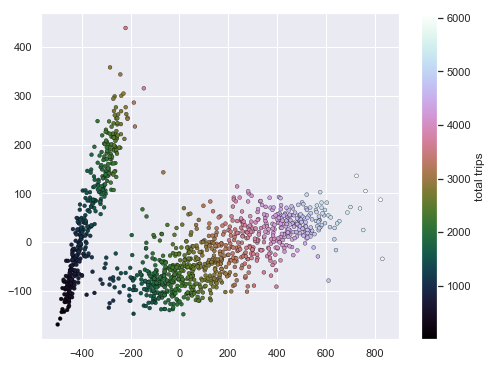

In [8]:
total_trips = X.sum(1) # 每一日總流量 為X的第二維資料(一天中的48個觀測值)的總和

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0],Xpca[:, 1], c=total_trips,
            s=15, cmap='cubehelix', edgecolors='black',linewidths=0.3)
# 參數說明：c=上色依據的數值，cmap=色彩對應表，edgecolors=點的邊框顏色，linewidths=邊框大小

plt.colorbar(label='total trips')

根據圖表，資料被區分成明顯的兩群，且自行車總流量隨著各群體的分布長軸漸增。此外，兩個群體的分界線在總流量的很低時，較不明顯。

以原始資料(僅經過排序處理)所畫的分布圖看來，可以推論出每日的自行車騎乘模式，主要有兩種型態。後續將繼續型塑這些集群，釐清這兩種型態的日子真正的差別是什麼。

## Unsupervised Clustering 非監督式聚類分析

當你有一群資料，你希望它們能夠在"不決定要分成哪些類別"的前提下自行分群，那麼你就需要*聚類分析(clustering)* 演算法的幫助。

聚類分析演算法的種類很多，但對於上面資料呈現明確的橢圓分布，[高斯混合模型Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) 非常符合我們的需求。

我們將再次透過scikit-learn使用高斯混合模型計算資料，並依據模型預測的聚類(分群)標籤，畫出圖表：

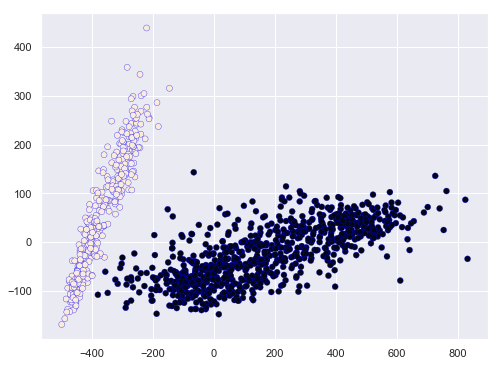

In [9]:
from sklearn.mixture import GaussianMixture # 匯入高斯混合模型函式庫
gmm = GaussianMixture(2, covariance_type='full', random_state=0) # 建立模型，2 表示分群標籤數
# covariance_type=估計各類別時，約束共變異數的方式

gmm.fit(Xpca) # 訓練模型
cluster_label = gmm.predict(Xpca) # 預測結果

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, edgecolors='blue',linewidths=0.3)
# c=上色依據的數值，edgecolors=點的邊框顏色，linewidths=邊框大小

之前PCA處理分好的兩個群體被塗上不同顏色，表示高斯混合模型所算出來幫資料分類的標籤，和前面分好的群體，分類的依據是相符的。
接下來我們要將推測出的兩個聚類標籤加入最初的數據集：

In [10]:
pivoted['Cluster'] = cluster_label # 在pivoted新增欄位:聚類標籤
data = data.join(pivoted['Cluster'], on=data.index.date) # 將pivoted新增的'Cluster'，依據時間索引轉貼回最初的data
data.head()

,West,East,Total,Cluster
Date,,,,
2015-11-15 02:00:00,0.0,0.0,0.0,1
2015-11-29 04:00:00,0.0,0.0,0.0,1
2015-11-21 02:00:00,0.0,0.0,0.0,1
2015-11-08 02:00:00,0.0,0.0,0.0,1
2015-11-08 04:00:00,0.0,0.0,0.0,1


我們讓每筆資料都被貼上分群後的標籤。
接下來，使用groupby函式，在更新後的數據集中，找出聚類、時間的平均值趨勢:

In [11]:
by_hour = data.groupby(['Cluster', data.index.time]).mean() # 將資料依據兩個cluster、一天中的24小時分群後，計算平均值
# 一個row表示 聚類0/1在 所有日期的某個時間整點 平均自行車流量為何
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  5.294982  6.192166  11.487148
        01:00:00  2.681763  2.947368   5.629131
        02:00:00  2.192166  1.751530   3.943696
        03:00:00  1.678091  1.399021   3.077111
        04:00:00  4.232558  2.778458   7.011016

最後，畫出兩個cluster資料，在一天當中每小時平均自行車流量趨勢圖：

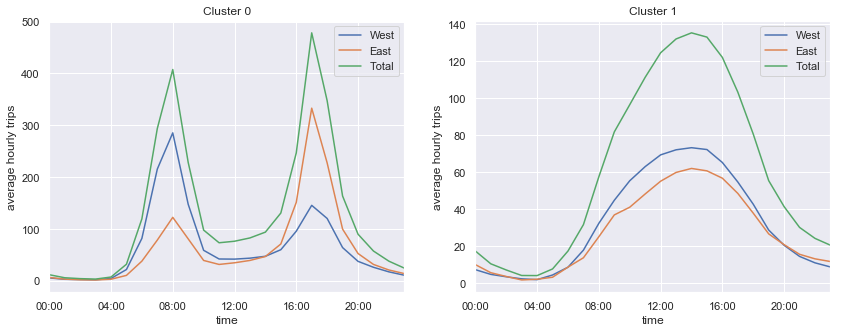

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) # 1,2表示分別畫出兩個圖表
hourly_ticks = 4 * 60 * 60 * np.arange(6) # 以小時做為刻度，之後做為X軸

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=hourly_ticks) # 分別取cluster 0/1
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

從這些圖表，我們能夠對被分成兩群的資料作出一些解釋：第一個聚類中，自行車流量隨時間推移呈現兩個尖峰分布，而第二個聚類呈現較寬的單峰分布。

在雙峰分布的群集中，可以看到一個高峰點出現在上午八點的時候，並且主要由西側的通道流量造成；另一個高峰點出現在下午五點，主要由東側通行道流量組成。這很明顯的是上班通勤的流量型態，早上騎自行車的人主要是前往西雅圖鬧區，下午則是以離開鬧區為主。

在單峰分布的群集中，我們在東西兩側通道看到相當穩定的交通型態，在早上漸增，到晚上則漸減，高峰時段出現在下午兩點左右。
整天騎乘自行車的人數呈穩定變化，這樣的型態和休假日從事休閒活動的型態非常相像。

目前就能感受到資料分析的有趣之處：從簡單的非監督式減少資料維度，以及聚類分析，我們可以從資料中發現兩個有著顯著差異的日子型態，並且可以對每個類別作出直覺的解釋。

## Seattle's Work Habits 西雅圖地區的工作習慣

我們將以目前的了解，做進一步探究，嘗試從西雅圖單車族獲得更多資訊。
在簡單的推測之後，你也許能猜到我們得到的兩個類別，第一個類別(Cluster 0)屬於上班日(週一到週五)，第二個類別(Cluster 1)則代表了非工作日(週六、日)。
為了確認我們的直覺，將再次畫出我們用來推測類別的資料(一筆資料代表一天)分布圖，並且以星期一~星期日為每筆資料上色：

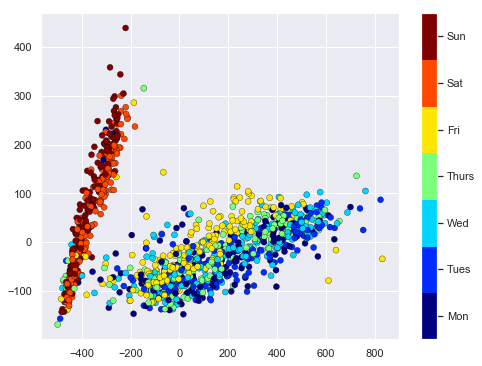

In [13]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
# 以dayofweek 表示 原本pivoted的索引(日期)，轉換回傳成以星期(dayofweek)表示的索引。

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7), edgecolors='black',linewidths=0.3)
# cmap以'jet'當作色彩對應，並間隔取出7個顏色

cb = plt.colorbar(ticks=range(7)) # 畫上色彩圖例
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5); # 限制色彩範圍

可以從上圖看到，先前平日/周末的直覺猜測大致上是對的，但有一點例外：**少數的平日出現在推測為非上班日型態的那一群之中**，
另一個有趣的現象，星期五的分布雖然毫無疑問的落在上班日的群體中，但是卻比其他平日更靠近非上班日的群體。

我們將仔細檢視少數落在"錯誤"群體的"特殊的"平日。
前置動作，建立一個data frame，列出每天的類別標籤以及是星期幾：

In [14]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)  # '%a'表示顯示 星期的縮寫
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


首先，我們先查看多少星期六、日是落在通勤導向的群體中。

In [15]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

0

推論出**2012/10/03~2015/12/31**這個時間區間中，沒有在周末需要上班的日子。

同樣的，我們可以查看有多少平日落在假日導向的群體中：

In [16]:
midweek_holidays = results.query('cluster == 1 and not is_weekend') # 符合條件(星期一~五，但落在假日導向的群體中)的列
len(midweek_holidays)

30

2012/10/03~2015/12/31這個時間區間中有30天平日，西雅圖的單車族整體看來沒有去上班。
為了標記這些資料，我們載入Pandas內建的美國國定假日日曆：

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar # 匯入美國國定假日日曆

cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True) # 需將結尾設定成2016，才會包含2015整年的節日
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

為了完整性，我們將這些節日的前後一天也加入列表中：

In [18]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

注意到這些是美國的*observed* holidays(當年節日如果落在六，則將其提前一天，改在星期五；落在星期日，則延後一天為星期一)，所以2012的新年01/01為星期日，所以順延一天，將01/02定為新年休假日。
有了以上的整理的資料及了解後，我們可以繼續探討上班日，但西雅圖自行車通勤族，選擇待在家的原因為何：

In [19]:
holidays_all.name = 'name'  # 執行 join 所需要
joined = midweek_holidays.join(holidays_all) 
# 使用join將國定假日清單，根據日期，加到對應的 前面取得的 midweek_holidays(屬於平日，但落在假日導向的群體中的日子)
set(joined['name']) # 取得欄位'name'的集合，看到'推測的星期一到五休假日'的種類有哪些

{'Christmas',
 'Day After Christmas',
 'Day After Thanksgiving',
 'Day Before Christmas',
 'Day Before New Years Day',
 'July 4th',
 'Labor Day',
 'MemorialDay',
 'New Years Day',
 'Thanksgiving'}

另一方面， 以下是國定放假的節日，但西雅圖自行車通勤族會選擇去上班：

In [20]:
set(holidays) - set(joined.name)

{'Columbus Day',
 'Dr. Martin Luther King Jr.',
 'Presidents Day',
 'Veterans Day'}

## Update: What's up with Fridays? 特別的星期五

原文作者的同事在後續發現一個特別的現象，大部分的星期五分布是落在上班日群體中，靠近假日群體的位置，但是，有明顯的3個離群值，這三除了和其他星期五有差距外，與其他的平日也有明顯區別

以下先將星期五在圖上做特別標記，可以更清楚看出這個現象：

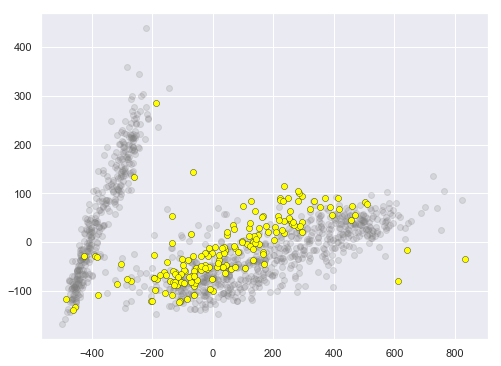

In [21]:
fridays = (dayofweek == 4)

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2) # 全部先塗上淡灰色
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow', edgecolors='black',linewidths=0.3); # 星期五塗上黃色

從上圖可以看出，在右下角的黃色點，他們離其他的星期五很遠，也與其他的上班日有區別

接著來看他們分別代表那些日子：

In [22]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] > 600)]
weird_fridays

Index([2013-05-17, 2014-05-16, 2015-05-15], dtype='object')

三個星期五都出現在五月中!

接來簡單的畫出，他們的當日流量狀態，並加上全體的平均流量。

我們可以利用pivot_table達成以上操作：

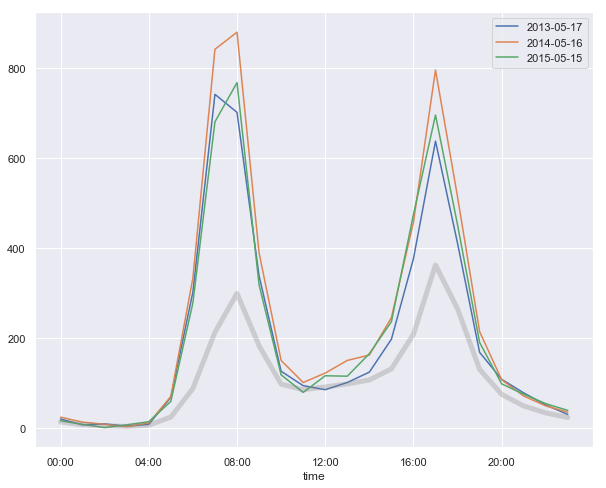

In [23]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
# 建立命名為 all_day的 pivot_tabel，放置原資料data中的total欄位，以24小時作為列索引，所有日期作為欄索引

plt.figure(figsize=(10, 8))
plt.plot(all_days.loc[:, weird_fridays]); # 取出weird_fridays畫圖

plt.plot(all_days.mean(1), color='gray', lw=5, alpha=0.3) # 畫平均值
# all_days.mean(1) 計算每行(每小時)的平均值
plt.legend(weird_fridays) # 畫上圖列，顯示那三天的日期
plt.xticks(hourly_ticks);

這三個特別的星期五，明顯有特別高的自行車通勤數量。
造成這種情形的原因是什麼呢？

經過在網路上的一翻搜尋後，發現它是西雅圖一年一度的[bike to work day](http://www.cascade.org/f5-bike-work-day)。
Mystery solved!

## Summary 第一部分總結

經過上面的練習，我們了解到，透過仔細觀察分析原始的自行車流量數據，並使用基礎的視覺化、非監督式機器學習，我們能夠將西雅圖騎自行車經過佛里蒙特橋的通勤族的上班習慣，做出明確的整體資料解釋。

總結來說，我們學到了以下資訊：

- 西雅圖自行車族整體來說，會傾向在 New Year's Day, Memorial Day, Independence Day, Labor Day, and the days surrounding Thanksgiving and Christmas放假。
- 西雅圖自行車族整體來說，會傾向在美國小型節日：Columbus Day, Martin Luther King Jr. Day, Presidents Day, and Veterans Day去上班。
- 西雅圖自行車族整體來說，永遠不會被發現周末跑去上班。